In [194]:
import numpy as np
from numpy.random import seed
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from uuid import uuid4
import json
import os

In [10]:
def irf(diff, disc, ability):
    return 1/(1+ np.exp(-disc*(ability-diff)))

In [160]:
def write_to_jsonlines(lst: list, filename: str):
    with open(filename,"w") as f:
        for line in lst:
            f.write(json.dumps(line))
            f.write(f"\n")
        

In [173]:
def get_fit_abilities(location: str):
    with open(os.path.join(location,"best_parameters.json"), "rb") as f:
        params = json.load(f)
        abilities = pd.DataFrame({"subject_id": params["subject_ids"].values(), "ability": params["ability"]})
        return abilities

In [27]:
#for reproducibility
seed(1)

In [35]:
str(uuid4())

'82262c5d-9e44-4ebd-9ddc-2f9f0a534d34'

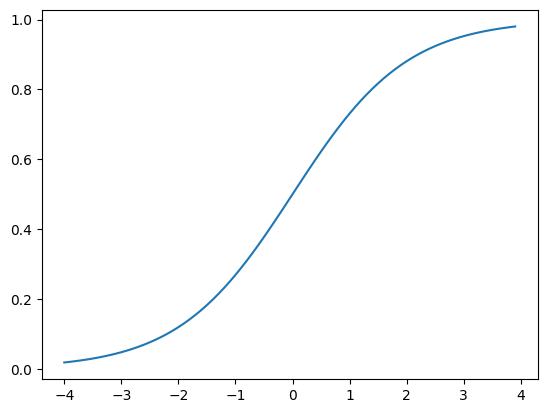

In [13]:
x = np.arange(-4,4,0.1)
y =irf(diff=0,disc=1,ability=x)
plt.plot(x,y)

generate some synthetic data

(array([  14.,  151.,  699., 1932., 2909., 2594., 1248.,  388.,   55.,
          10.]),
 array([-3.6930045 , -2.9169923 , -2.14098009, -1.36496789, -0.58895569,
         0.18705652,  0.96306872,  1.73908092,  2.51509313,  3.29110533,
         4.06711753]),
 <BarContainer object of 10 artists>)

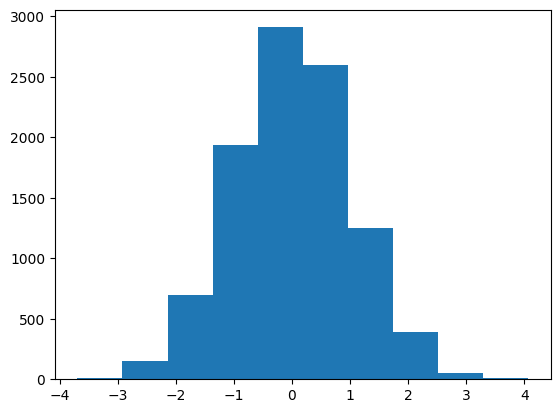

In [29]:
abilities = np.random.normal(size=10000,loc=0,scale=1.01)
difficulties =   np.random.normal(size=100,loc=0,scale=1.01)
discriminations = np.random.normal(size=100,loc=0,scale=1.01)

plt.hist(abilities)

In [24]:
#generate abilities
#generate questions (ie, diff and disc)
#using the diff, disc, and abilities, you know what the probabilities are that any particular student would answer that question correctly.
#so use that to generate responses for each student and each question

In [46]:
subjects = pd.DataFrame({"id": [str(uuid4()) for i in range(10_000) ], "ability": abilities})
items = pd.DataFrame({"id": [str(uuid4()) for i in range(100)], "difficulty": difficulties, "discrimination": discriminations })

In [39]:
subjects

,id,ability
0,21efc818-50df-4ac4-a611-b2f8955c3b2c,1.640589
1,763a0373-5992-43e5-b474-727f2598dc46,-0.617874
2,29b738a3-b72a-4bba-9c26-c55b61b59410,-0.533453
3,14b3cd59-bc3c-4aba-b22a-3ac3143b4885,-1.083698
4,f3fba37b-d874-4fc9-aabe-d18d643d1295,0.874062
...,...,...
9995,6d5543f8-e5cd-4b41-bace-7a7d2298dd23,0.073688
9996,7829c7c5-1c46-4aa2-bbdb-24963ac3a003,0.493993
9997,6ef88c5c-2eeb-4f19-b5cc-beda7e7eaf55,-1.024285
9998,1135e886-a079-4f20-9092-f0911ef42219,-0.063323


In [44]:
items

,id,difficulty,discrimination
0,8325264c-384d-4f77-8288-df5ce6d5db26,-0.123699,-1.475666
1,83e88c26-9581-44bd-a615-8bd9874837d3,0.230452,1.489526
2,63a69d26-082f-455f-aa02-eb8f94bc233f,-0.355828,1.215772
3,49ffdb94-a0f3-4169-9b4d-70256f1c37aa,-0.838859,0.739943
4,9b693ed3-f5c5-4478-89ed-c9ff1272a9c8,-0.263701,0.852650
...,...,...,...
95,15e34207-4d04-474a-b6d9-ec80a3ea55b6,-0.402485,-1.117401
96,273e35f6-a171-47ed-a30d-3ac6d615ba0f,0.368278,1.505461
97,fe2fcb52-3b27-4ece-9871-2cf513e288ad,-0.158742,0.124914
98,d34876bb-d49b-439c-8978-78a7a4a9c491,0.544037,-1.799727


## Generate responses

In [49]:
[{"subject_id": subject_id, **{item_id: np.random.binomial(n=1,p=irf(diff=difficulties,disc=discriminations,ability=0))

array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0])

In [59]:
items

,id,difficulty,discrimination
0,82938f30-c85d-4d1f-8045-8c40377e1d36,-0.123699,-1.475666
1,06a8ac90-bcd7-444b-b27d-f672ca817546,0.230452,1.489526
2,daa1afca-7b75-457c-9a9c-392453bc9150,-0.355828,1.215772
3,fab9cd87-6dce-41f2-9e13-f691bb57e786,-0.838859,0.739943
4,60dc652e-8640-4e3e-bfe2-8ce15fdedbb3,-0.263701,0.852650
...,...,...,...
95,da78ab2e-5202-437a-8a3f-c33ea0f01ce0,-0.402485,-1.117401
96,51bf181d-e2f4-413d-b1e0-d869a2d9edf9,0.368278,1.505461
97,e9958f56-a4ec-4196-acfa-2bb37d33b927,-0.158742,0.124914
98,3c2e0ecf-958d-4df2-8cbc-c1740807936c,0.544037,-1.799727


In [90]:
def generate_subject_responses(subject):

    item_responses = items.apply(lambda item: {item["id"]: np.random.binomial(n=1,p=irf(diff=item["difficulty"],disc=item["discrimination"],ability=subject["ability"]))},axis=1).tolist()
    item_responses = {"subject_id": subject["id"], "responses": {k:v for item in item_responses for k,v in item.items()}}
    return item_responses

In [107]:
subject_responses = subjects.apply(generate_subject_responses,axis=1)

In [120]:
#make jsonlines
subject_responses = subject_responses.tolist()

In [158]:
write_to_jsonlines(subject_responses, "synthetic_subjects.jsonl")

In [191]:
!py-irt train 2pl synthetic_subjects.jsonl 2pl-params/ --lr 0.02 --epochs 1000 --deterministic
#!py-irt train 2pl synthetic_subjects.jsonl 2pl-params/  --epochs 2000 --deterministic


[18:08:45] config: model_type='2pl' epochs=2000 priors=None           ]8;id=1699312125.1538522-592772;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:109
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                     
           dropout=0.5 hidden=100 vocab_size=None log_every=100                 
           seed=None deterministic=True                                         
           data_path: synthetic_subjects.jsonl                        ]8;id=1699312125.154968-357424;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:111
           output directory: 2pl-params/                              ]8;id=1699312125.1558115-45597;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:112
[18:08:45] amortized: False                                       ]8;id=1699312125.6603694-116050;file:///home/daavid/PycharmProjec

In [186]:
fit_abilities = get_fit_abilities("2pl-params")

In [187]:
fit_abilities

,subject_id,ability
0,490476a8-5f5e-46df-866a-445f1c1aa78b,0.793830
1,efa7e766-7499-4929-94b1-133b68357371,-0.812192
2,0faad1c6-d696-4711-9618-2515a8202627,-0.425668
3,2f0cee3f-0d34-4da0-95c9-7e598c48a946,-1.268716
4,e43099ee-ff65-4e3a-b18c-49774b8fae16,1.130557
...,...,...
9995,3992902b-eb34-4e95-a3ce-56ff6c5f479b,-0.948364
9996,d4f0bb46-4a95-479c-a453-f48cb44a9641,-0.233355
9997,5b75801b-f253-4b4d-a84a-67bcceb657a7,-0.373027
9998,67763870-e0e5-4b42-9ece-f3e5b749fead,-0.877810


In [188]:
true_pred = fit_abilities.merge(subjects, left_on="subject_id", right_on="id", suffixes=("_pred","_true"))

In [189]:
true_pred

,subject_id,ability_pred,id,ability_true
0,490476a8-5f5e-46df-866a-445f1c1aa78b,0.793830,490476a8-5f5e-46df-866a-445f1c1aa78b,1.640589
1,efa7e766-7499-4929-94b1-133b68357371,-0.812192,efa7e766-7499-4929-94b1-133b68357371,-0.617874
2,0faad1c6-d696-4711-9618-2515a8202627,-0.425668,0faad1c6-d696-4711-9618-2515a8202627,-0.533453
3,2f0cee3f-0d34-4da0-95c9-7e598c48a946,-1.268716,2f0cee3f-0d34-4da0-95c9-7e598c48a946,-1.083698
4,e43099ee-ff65-4e3a-b18c-49774b8fae16,1.130557,e43099ee-ff65-4e3a-b18c-49774b8fae16,0.874062
...,...,...,...,...
9995,3992902b-eb34-4e95-a3ce-56ff6c5f479b,-0.948364,3992902b-eb34-4e95-a3ce-56ff6c5f479b,0.073688
9996,d4f0bb46-4a95-479c-a453-f48cb44a9641,-0.233355,d4f0bb46-4a95-479c-a453-f48cb44a9641,0.493993
9997,5b75801b-f253-4b4d-a84a-67bcceb657a7,-0.373027,5b75801b-f253-4b4d-a84a-67bcceb657a7,-1.024285
9998,67763870-e0e5-4b42-9ece-f3e5b749fead,-0.877810,67763870-e0e5-4b42-9ece-f3e5b749fead,-0.063323


<Axes: >

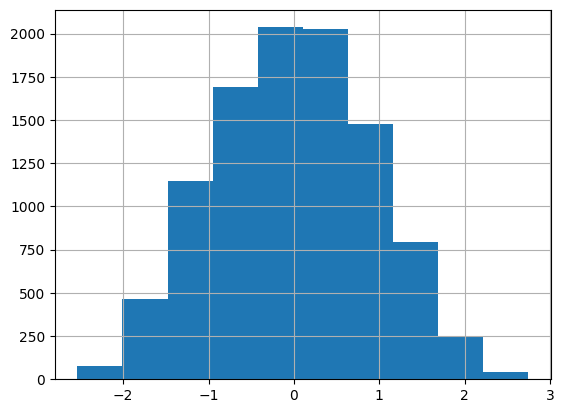

In [196]:
true_pred["ability_pred"].hist()

<Axes: >

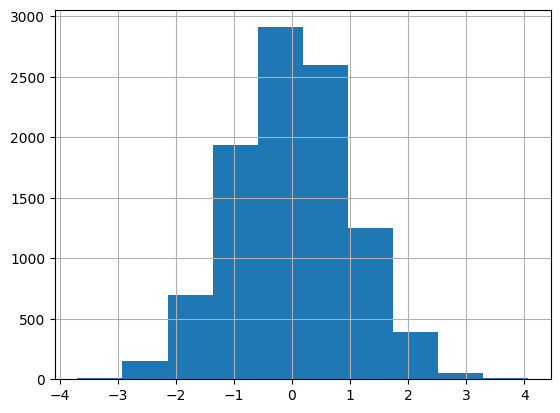

In [184]:
true_pred["ability_true"].hist()

<Axes: >

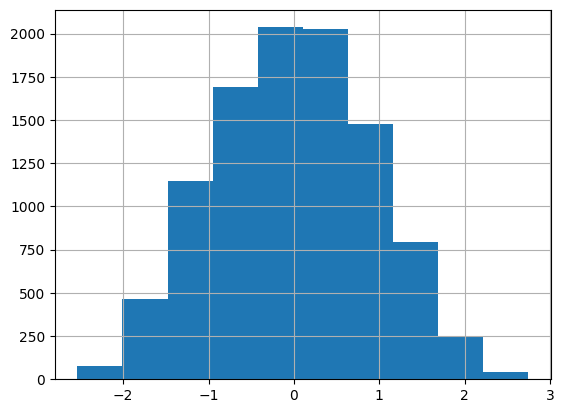

In [193]:
#2000 epoch
true_pred["ability_pred"].hist()